In [36]:
# from google.colab import drive
# drive.mount('/content/drive')

# **Data Preparation**

In [37]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
# import cv2
# import skimage
# from skimage.util import random_noise
import tensorflow as tf

from tqdm.notebook import tqdm
import random

In [38]:
# from sklearn.model_selection import train_test_split

# noisy_array_paths, gt_array_paths = get_images_paths("SIDD_Small_sRGB_Only", "Mi3_Aligned", "NIND")

# noisy_train_paths, noisy_test_paths, gt_train_paths, gt_test_paths = train_test_split(noisy_array_paths, gt_array_paths, test_size=0.20, random_state=42)
import tensorflow as tf
tf.get_logger().setLevel("ERROR")
tf.keras.mixed_precision.set_global_policy("mixed_float16")

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import os
import numpy as np

# data = np.loadtxt(os.path.join('rawdata', '2150_dataset.csv'), delimiter=";")
# data = np.loadtxt('2150_dataset.csv', delimiter=";")
data = np.loadtxt('2150_validation.csv', delimiter=";")
data = np.c_[data, np.zeros(len(data)), np.zeros(len(data))]#.astype(np.float16)
if np.isnan(data).any():
    print("ERROR")

data_valid = np.loadtxt('2150_validation.csv', delimiter=";")
data_valid = np.c_[data_valid, np.zeros(len(data_valid)), np.zeros(len(data_valid))]#.astype(np.float16)
if np.isnan(data_valid).any():
    print("ERROR")

print(data.shape, data_valid.shape)

(2345, 2152) (2345, 2152)


In [39]:
### source 350-2500
# subrange, machine = np.s_[0:512], "random"
subrange, machine = np.s_[550:1250], "viavi"
# subrange, machine = np.s_[1000:2100], "nirone-sensor-S"
# subrange, machine = np.s_[1200:1600], "nirone-sensor-X"

x_scaler = MinMaxScaler()
x_scaler = x_scaler.fit(data.reshape(-1, data.shape[-1]))
y_train = x_scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
y_test = x_scaler.fit_transform(data_valid.reshape(-1, data_valid.shape[-1])).reshape(data_valid.shape)
X_train = y_train[:, subrange]
X_test = y_test[:, subrange]


# X_train, X_test, data_train, data_test = train_test_split(x, data, test_size=0.5, random_state=42, shuffle=False)
# cut = 15000
# X_train, X_test, y_train, y_test = data_train[:cut,:], x[cut:,:], data_train[:cut,:], data[cut:,:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(2345, 700) (2345, 2152) (2345, 700) (2345, 2152)


In [40]:
# print(noisy_train_paths.shape)
# print(noisy_test_paths.shape)
# print(gt_train_paths.shape)
# print(gt_test_paths.shape)

In [41]:
# # Get gt_images in memory
# def get_images_in_mem(images_paths):
#     images_lst = []
#     for img_path in tqdm(images_paths):
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.resize(img, (256, 256))
#         images_lst.append(img)
#     return np.array(images_lst)

In [42]:
# noisy_train_images = get_images_in_mem(noisy_train_paths)
# noisy_test_images = get_images_in_mem(noisy_test_paths)

# gt_train_images = get_images_in_mem(gt_train_paths)
# gt_test_images = get_images_in_mem(gt_test_paths)
# data_valid = np.c_[data_valid, np.zeros(len(data_valid)), np.zeros(len(data_valid))]#.astype(np.float16)
# print(len(X_train), subrange.start-1)
# print(len(X_train), y_train.shape[1] - subrange.stop)
noisy_train_images = np.c_[np.zeros((len(X_train), subrange.start)), X_train, np.zeros((len(X_train), y_train.shape[1] - subrange.stop))]
noisy_test_images = np.c_[np.zeros((len(X_test),subrange.start)), X_test, np.zeros((len(X_test), y_test.shape[1] - subrange.stop))]

print(noisy_train_images.shape)
print(noisy_test_images.shape)

gt_train_images = y_train
gt_test_images = y_test
print(gt_train_images.shape)
print(gt_test_images.shape)

(2345, 2152)
(2345, 2152)
(2345, 2152)
(2345, 2152)


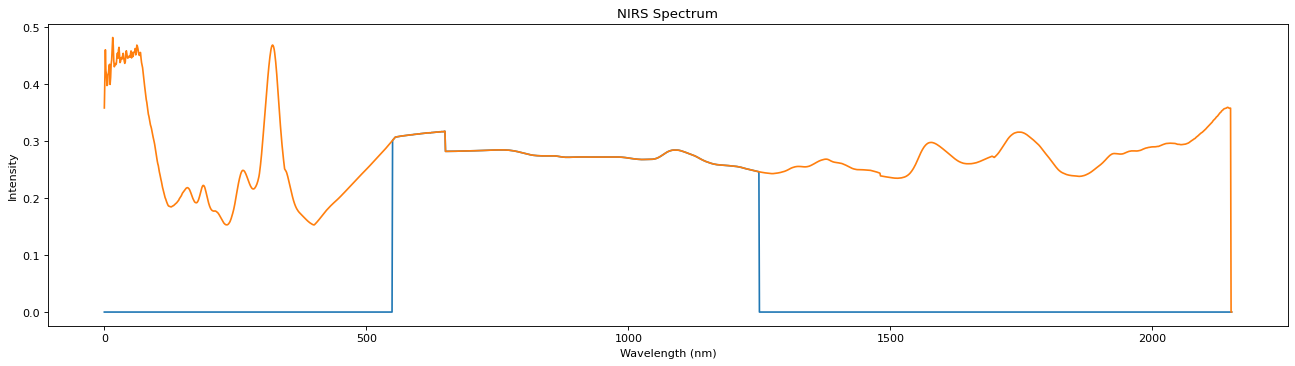

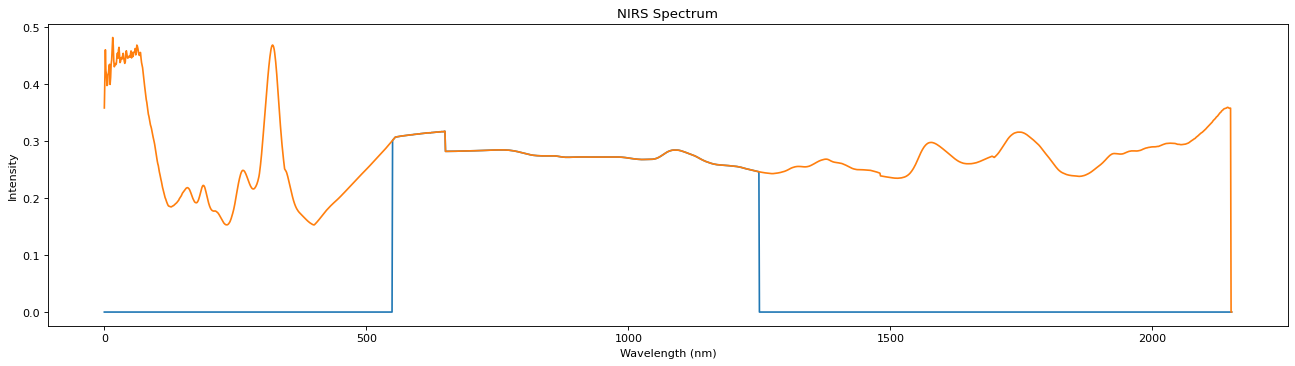

In [43]:
# f, axarr = plt.subplots(1,2, figsize=(14,14))
# axarr[0].imshow(noisy_train_images[5])
# axarr[0].set_title("Noisy image")
# axarr[1].imshow(gt_train_images[5])
# axarr[1].title.set_text("Ground Truth image")

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error
import random

def display_spectrum(spectra):
    figure(figsize=(20, 5), dpi=80)
    x_axis = np.arange(2152)
    increment = 0
    for s in spectra:
        if len(s) < 2152:
            plt.plot(np.arange(subrange.start,subrange.stop,1), s + increment, linewidth=1)
        else:
            plt.plot(x_axis, s + increment)
        # increment += 0.1
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title('NIRS Spectrum')
    plt.show()


display_spectrum([noisy_train_images[1], gt_train_images[1]])
display_spectrum([noisy_test_images[1], gt_test_images[1]])

In [44]:
# def _up_down_flip(image, label):
#     image = tf.image.flip_up_down(image)
#     label = tf.image.flip_up_down(label)
#     return image, label

# def _left_right_flip(image, label):
#     image = tf.image.flip_left_right(image)
#     label = tf.image.flip_left_right(label)
#     return image, label

# def _rotate(image, label):
#     random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
#     image = tf.image.rot90(image, random_angle)
#     label = tf.image.rot90(label, random_angle)
#     return image, label

# def _hue(image, label):
#     rand_value = random.uniform(-1,1)
#     image = tf.image.adjust_hue(image, rand_value)
#     label = tf.image.adjust_hue(label, rand_value)
#     return image, label

# def _brightness(image, label):
#     rand_value = random.uniform(-0.08,0.25)
#     image = tf.image.adjust_brightness(image, rand_value)
#     label = tf.image.adjust_brightness(label, rand_value)
#     return image, label

# def _saturation(image, label):
#     rand_value = random.uniform(1, 5)
#     image = tf.image.adjust_saturation(image, rand_value)
#     label = tf.image.adjust_saturation(label, rand_value)
#     return image, label

# def _contrast(image, label):
#     rand_value = random.uniform(1, 3)
#     image = tf.image.adjust_contrast(image, rand_value)
#     label = tf.image.adjust_contrast(label, rand_value)
#     return image, label

# What does batch, repeat, and shuffle do with TensorFlow Dataset?
# https://stackoverflow.com/q/53514495/7697658
def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE=2
# # augmentation_lst = [_up_down_flip, _left_right_flip, _rotate, _hue, _brightness, _saturation, _contrast]
# augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
image_generator_train = tf_data_generator(X=noisy_train_images, y=gt_train_images, batch_size=BATCH_SIZE)
image_generator_test = tf_data_generator(X=noisy_test_images, y=gt_test_images, batch_size=BATCH_SIZE)

In [45]:
# image_generator_train

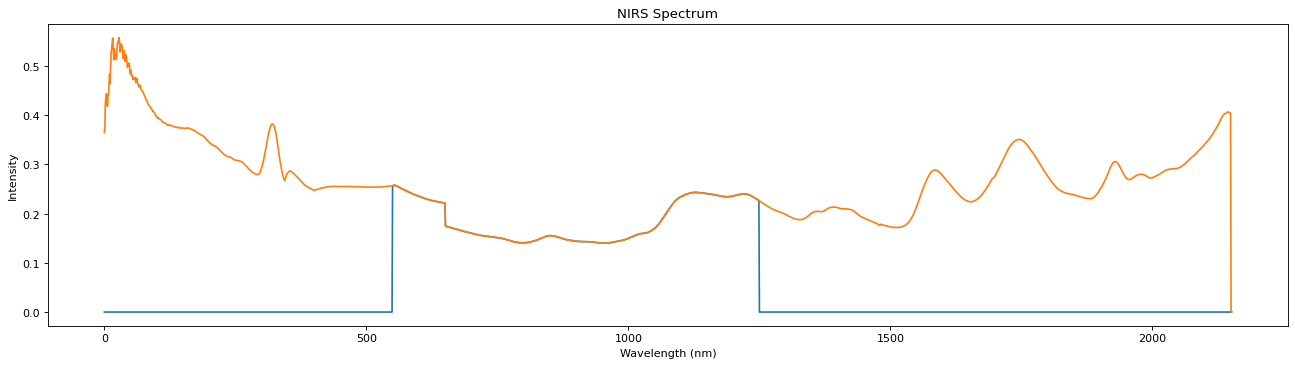

In [46]:
# # SANITY CHECK of the Dataset generator
# for noisy, gt in image_generator_train.take(1):  # only take first element of dataset
#     numpy_images = noisy.numpy()
#     numpy_labels = gt.numpy()

# f, axarr = plt.subplots(1,2, figsize=(14,14))
# axarr[0].imshow(numpy_images[1])
# axarr[0].set_title("X-data noisy image")
# axarr[0].set_axis_off()

# axarr[1].imshow(numpy_labels[1])
# axarr[1].set_title("y-data ground truth image")
# axarr[1].set_axis_off()

display_spectrum([noisy_train_images[-1], gt_train_images[-1]])

# **PRIDNet**
<a href='https://arxiv.org/pdf/1908.00273.pdf'>https://arxiv.org/pdf/1908.00273.pdf</a>


In [47]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    # GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    # BatchNormalization, Activation, Flatten, Dense, Input,\
                                    # Add, Multiply, Concatenate, concatenate, Softmax
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, Reshape, Cropping1D,\
                                    GlobalAveragePooling1D, AveragePooling1D, MaxPool1D, UpSampling1D,\
                                    BatchNormalization, Activation, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')

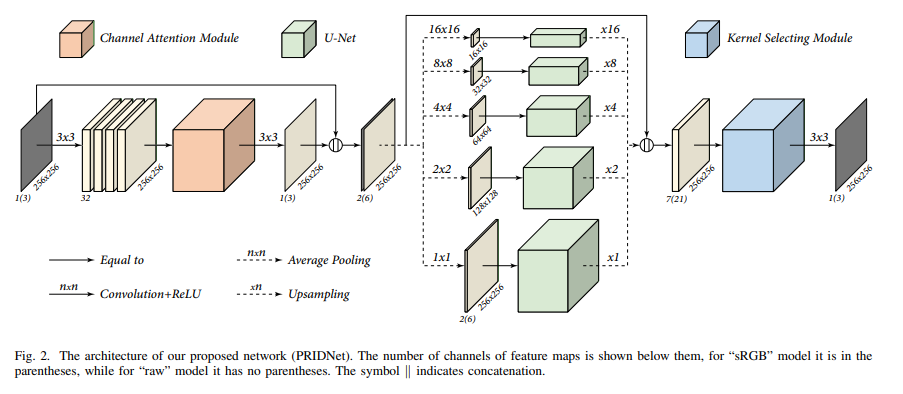

In [48]:
class Convolutional_block(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv1D(filters=64, kernel_size=3, strides=1, padding='same')
        self.conv_2 = Conv1D(filters=64, kernel_size=3, strides=1, padding='same')
        self.conv_3 = Conv1D(filters=64, kernel_size=3, strides=1, padding='same')
        self.conv_4 = Conv1D(filters=64, kernel_size=3, strides=1, padding='same')

    def call(self, X):
        X_1 = self.conv_1(X)
        X_1 = Activation('relu')(X_1)

        X_2 = self.conv_2(X_1)
        X_2 = Activation('relu')(X_2)

        X_3 = self.conv_3(X_2)
        X_3 = Activation('relu')(X_3)

        X_4 = self.conv_4(X_3)
        X_4 = Activation('relu')(X_4)
        
        #print('---conv block=',X_4.shape)
        
        return X_4

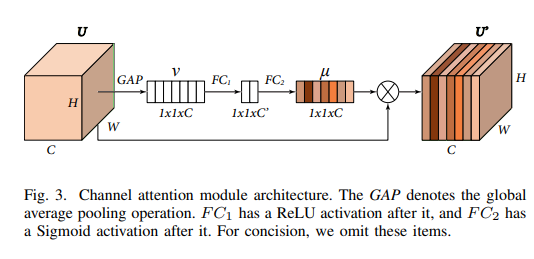

In [49]:
class Channel_attention(tf.keras.layers.Layer):
    def __init__(self, C=64, **kwargs):
        super().__init__(**kwargs)
        self.C=C
        self.gap = GlobalAveragePooling1D()
        self.dense_middle = Dense(units=2, activation='relu')
        self.dense_sigmoid = Dense(units=self.C, activation='sigmoid')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        v = self.gap(X)
        #print("ca_ after gap =",v.shape)
        fc1 = self.dense_middle(v)
        #print("ca_ after fc1 =",fc1.shape)
        mu = self.dense_sigmoid(fc1)
        #print("ca_ after fc2 =",mu.shape)

        U_out = Multiply()([X, mu])
        
        #print('---channel attention block=',U_out.shape)

        return U_out

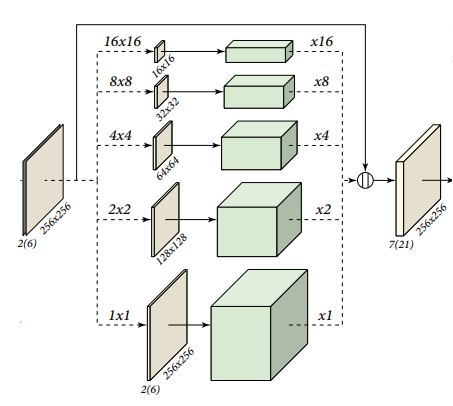

In [63]:
class Avg_pool_Unet_Upsample_msfe(tf.keras.layers.Layer):
    def __init__(self, avg_pool_size, upsample_rate, **kwargs):
        super().__init__(**kwargs)
        # ---initialization for Avg pooling---
        self.avg_pool = AveragePooling1D(pool_size=avg_pool_size, padding='same')

        # --- initialization for Unet---
        self.deconv_lst = []
        filter=512
        for i in range(4):
            self.deconv_lst.append(Conv1DTranspose(filters=filter/2, kernel_size=3, strides=2, padding='same'))
            filter/=2


        filter_count = 16
        self.conv_32_down_lst = []
        for i in range(4):
            self.conv_32_down_lst.append(Conv1D(filters=filter_count, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_down_lst = []
        for i in range(4):
            self.conv_64_down_lst.append(Conv1D(filters=filter_count*2, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_down_lst = []
        for i in range(4):
            self.conv_128_down_lst.append(Conv1D(filters=filter_count*4, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_down_lst = []
        for i in range(4):
            self.conv_256_down_lst.append(Conv1D(filters=filter_count*8, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_512_down_lst = []
        for i in range(4):
            self.conv_512_down_lst.append(Conv1D(filters=filter_count*16, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_32_up_lst = []
        for i in range(3):
            self.conv_32_up_lst.append(Conv1D(filters=filter_count, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_up_lst = []
        for i in range(3):
            self.conv_64_up_lst.append(Conv1D(filters=filter_count*2, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_up_lst = []
        for i in range(3):
            self.conv_128_up_lst.append(Conv1D(filters=filter_count*4, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_up_lst = []
        for i in range(3):
            self.conv_256_up_lst.append(Conv1D(filters=filter_count*8, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_3 = Conv1D(filters=3, kernel_size=1)

        self.pooling1_unet = MaxPool1D(pool_size=2, padding='same')
        self.pooling2_unet = MaxPool1D(pool_size=2, padding='same')
        self.pooling3_unet = MaxPool1D(pool_size=2, padding='same')
        self.pooling4_unet = MaxPool1D(pool_size=2, padding='same')

        # ---initialization for Upsampling---
        self.upsample = UpSampling1D(upsample_rate)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'avg_pool_size': self.avg_pool_size,
            'upsample_rate':self.upsample_rate
        })
        return config

    def upsample_and_concat(self, x1, x2, i):
        deconv = self.deconv_lst[i](x1)
        deconv_output = Concatenate()([deconv, x2])
        return deconv_output

    def unet(self, input):
        # ---Unet downsampling---
        conv1 = input
        for c_32 in self.conv_32_down_lst:
            conv1 = c_32(conv1)
        pool1 = self.pooling1_unet(conv1)

        conv2 = pool1
        for c_64 in self.conv_64_down_lst:
            conv2 = c_64(conv2)
        pool2 = self.pooling2_unet(conv2)

        conv3 = pool2
        for c_128 in self.conv_128_down_lst:
            conv3 = c_128(conv3)
        pool3 = self.pooling3_unet(conv3)

        conv4 = pool3
        for c_256 in self.conv_256_down_lst:
            conv4 = c_256(conv4)
        pool4 = self.pooling4_unet(conv4)

        conv5 = pool4
        for c_512 in self.conv_512_down_lst:
            conv5 = c_512(conv5)

        # ---Unet upsampling---
        
        up6 = self.upsample_and_concat(conv5, conv4, 0)
        conv6 = up6
        for c_256 in self.conv_256_up_lst:
            conv6 = c_256(conv6)

        up7 = self.upsample_and_concat(conv6, conv3, 1)
        conv7 = up7
        for c_128 in self.conv_128_up_lst:
            conv7 = c_128(conv7)

        up8 = self.upsample_and_concat(conv7, conv2, 2)
        conv8 = up8
        for c_64 in self.conv_64_up_lst:
            conv8 = c_64(conv8)

        up9 = self.upsample_and_concat(conv8, conv1, 3)
        conv9 = up9
        for c_32 in self.conv_32_up_lst:
            conv9 = c_32(conv9)

        conv10 = self.conv_3(conv9)
        return conv10

    def call(self, X):
        avg_pool = self.avg_pool(X)
        #print("ap =",avg_pool.shape)
        unet = self.unet(avg_pool)
        upsample = self.upsample(unet)
        return upsample

In [51]:
class Multi_scale_feature_extraction(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.msfe_16 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=16, upsample_rate=16)
        # self.msfe_8 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=8, upsample_rate=8)
        self.msfe_4 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=4, upsample_rate=4)
        # self.msfe_2 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=2, upsample_rate=2)
        self.msfe_1 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=1, upsample_rate=1)

    def call(self, X):
        up_sample_16 = self.msfe_16(X)
        # up_sample_8 = self.msfe_8(X)
        up_sample_4 = self.msfe_4(X)
        # up_sample_2 = self.msfe_2(X)
        up_sample_1 = self.msfe_1(X)
        # msfe_out = Concatenate()([X, up_sample_16, up_sample_8, up_sample_4, up_sample_2, up_sample_1])
        msfe_out = Concatenate()([X, up_sample_16, up_sample_4, up_sample_1])

        #print('---Multi scale feature extraction block=',msfe_out.shape)
        return msfe_out

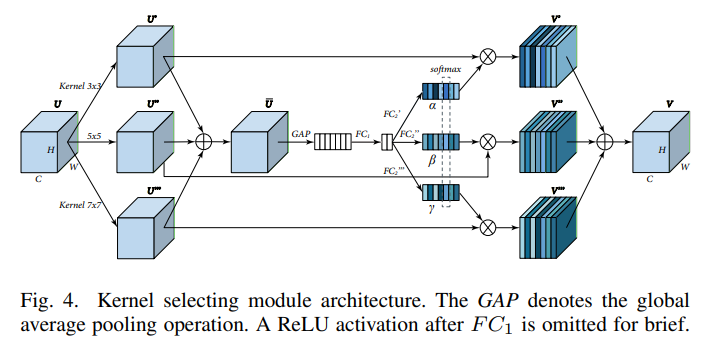

In [52]:
class Kernel_selecting_module(tf.keras.layers.Layer):
    def __init__(self, C=21, **kwargs):
        super().__init__(**kwargs)
        self.C = C
        self.c_3 = Conv1D(filters=self.C, kernel_size=3, strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_5 = Conv1D(filters=self.C, kernel_size=5, strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_7 = Conv1D(filters=self.C, kernel_size=7, strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.gap = GlobalAveragePooling1D()
        self.dense_two = Dense(units=2, activation='relu')
        self.dense_c1 = Dense(units=self.C)
        self.dense_c2 = Dense(units=self.C)
        self.dense_c3 = Dense(units=self.C)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        X_1 = self.c_3(X)
        X_2 = self.c_5(X)
        X_3 = self.c_7(X)

        X_dash = Add()([X_1, X_2, X_3])

        v_gap = self.gap(X_dash)
        v_gap = tf.reshape(v_gap, [-1, 1, 1, self.C])
        fc1 = self.dense_two(v_gap)

        alpha = self.dense_c1(fc1)
        beta = self.dense_c2(fc1)
        gamma = self.dense_c3(fc1)

        before_softmax = concatenate([alpha, beta, gamma], 1)
        # print(before_softmax.shape)
        after_softmax = softmax(before_softmax, axis=1)
        a1 = after_softmax[:, 0, :, :]
        # print(a1)
        a1 = tf.reshape(a1, [-1, 1, 1, self.C])
        # print(a1)
        a2 = after_softmax[:, 1, :, :]
        a2 = tf.reshape(a2, [-1, 1, 1, self.C])
        a3 = after_softmax[:, 2, :, :]
        a3 = tf.reshape(a3, [-1, 1, 1, self.C])

        select_1 = Multiply()([X_1, a1])
        select_2 = Multiply()([X_2, a2])
        select_3 = Multiply()([X_3, a3])

        out = Add()([select_1, select_2, select_3])

        return out

In [64]:
def create_model():
    # ca_block = Channel Attention block
    # msfe_block = Multi scale feature extraction block
    # ksm = Kernel Selecting Module
    tf.keras.backend.clear_session()

    input = Input(shape=(2152), name="input_layer")
    print("Input =",input.shape)
    x = Reshape((2152,1))(input)
    cropped = Cropping1D(948)(x)

    conv_block = Convolutional_block()(cropped)
    print("Conv block =",conv_block.shape)
    ca_block = Channel_attention()(conv_block)
    print("Channel Attention =",ca_block.shape)
    ca_block = Conv1D(filters=3, kernel_size=3, strides=1, padding='same')(ca_block)
    print("Channel Attention Last CNN =",ca_block.shape)
    ca_block = Concatenate()([cropped, ca_block])
    print("First phase =",ca_block.shape)
    print()

    msfe_block = Multi_scale_feature_extraction()(ca_block)

    print("Multi-scale feature extraction =",msfe_block.shape)

    ksm = Kernel_selecting_module()(msfe_block)
    ksm = Conv1D(filters=3, kernel_size=3, strides=1, padding='same')(ksm)
    ## ADDED by crg
    ksm = Dense(2152)(ksm)
    ##
    print("Kernel Selection Module =",ksm.shape)
    model = Model(inputs=[input], outputs=[ksm])
    return model

model = create_model()
model.summary()

Input = (None, 2152)
Conv block = (None, 256, 64)
Channel Attention = (None, 256, 64)
Channel Attention Last CNN = (None, 256, 3)
First phase = (None, 256, 4)

Multi-scale feature extraction = (None, 256, 13)
Kernel Selection Module = (None, 1, 256, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 2152)]       0           []                               
                                                                                                  
 reshape (Reshape)              (None, 2152, 1)      0           ['input_layer[0][0]']            
                                                                                                  
 cropping1d (Cropping1D)        (None, 256, 1)       0           ['reshape[0][0]']                
                                       

In [55]:
tf.keras.utils.plot_model(model=model, to_file='model_plot.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# **Training**

In [65]:
steps_per_epoch_train = len(noisy_train_images)
steps_per_epoch_validation = len(noisy_test_images)

In [66]:
best_models_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/"
callbacks_lst = [
                 tf.keras.callbacks.ModelCheckpoint(filepath="best_PRIDNet_blindnoise_256x256.h5", period=10, save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=3, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10)
]

In [67]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0009))
model.fit(image_generator_train, 
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        epochs=150,
                        verbose=1,
                        callbacks=callbacks_lst)

Epoch 1/150


ValueError: in user code:

    File "d:\Workspace\ML\pynirsENV\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "d:\Workspace\ML\pynirsENV\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Workspace\ML\pynirsENV\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "d:\Workspace\ML\pynirsENV\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "d:\Workspace\ML\pynirsENV\lib\site-packages\keras\engine\training.py", line 949, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses)
    File "d:\Workspace\ML\pynirsENV\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "d:\Workspace\ML\pynirsENV\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "d:\Workspace\ML\pynirsENV\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "d:\Workspace\ML\pynirsENV\lib\site-packages\keras\losses.py", line 1327, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 256 and 2 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_HALF](model/conv1d_107/squeeze_batch_dims/Reshape_1, Cast)' with input shapes: [2,1,256,3], [2,2152].


In [ ]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.00003))
model.fit(image_generator_train, 
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        epochs=100,
                        verbose=1,
                        callbacks=callbacks_lst)

In [ ]:
best_models_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/"
model.save(best_models_path+"best_PRIDNet_blindnoise_256x256.h5")

# **Inference**

In [ ]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)
    
    return predicted_image[0]

In [ ]:
def inference_batch_images(model, noisy_images):
    predicted_image = model.predict(noisy_images)
    return predicted_image

In [ ]:
def visualize_predictions(model, X_test, y_test, n):
    random_numbers = random.choices(range(X_test.shape[0]), k=n)    # Get n random indices
    for i in random_numbers:
        noisy_image = X_test[i]
        gt_image = y_test[i]
        predicted_image = inference_single_image(model, X_test[i])
        predicted_image/=255

        f, axarr = plt.subplots(1,3, figsize=(21,21))
        axarr[0].imshow(noisy_image)
        axarr[0].set_title("Noisy image")
        axarr[0].set_axis_off()
        axarr[1].imshow(gt_image)
        axarr[1].set_title("Ground truth image")
        axarr[1].set_axis_off()
        axarr[2].imshow(predicted_image)
        axarr[2].set_title("Predicted image")
        axarr[2].set_axis_off()

In [ ]:
best_models_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/"
model = tf.keras.models.load_model(best_models_path+'best_PRIDNet_blindnoise_256x256.h5', custom_objects={'Convolutional_block': Convolutional_block,
                                                                                                        'Channel_attention':Channel_attention,
                                                                                                        'Avg_pool_Unet_Upsample_msfe':Avg_pool_Unet_Upsample_msfe,
                                                                                                        'Multi_scale_feature_extraction':Multi_scale_feature_extraction,
                                                                                                        'Kernel_selecting_module':Kernel_selecting_module})

In [ ]:
visualize_predictions(model, noisy_test_images, gt_test_images, 10)

In [ ]:
# Test image prediction
banana = "NIND_banana_ISOH3.png"
kibbles = "NIND_kibbles_ISOH3.png"
library = "NIND_BruegelLibraryS1_NZ.png"
parrots = "kodim23-noise-std51.png"
eye = "eye_closeup_smaller_DIM25_noise_stddev_51.png"

img_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/MWCNN/"+eye

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

predicted_image = inference_single_image(model, img)
predicted_image/=255

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(img)
axarr[0].title.set_text("Noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(predicted_image)
axarr[1].title.set_text("Predicted image")
axarr[1].set_axis_off()

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images.shape[0]
psnr_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images.shape[0]
ssim_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

In [ ]:
from prettytable import PrettyTable

pt = PrettyTable()
print("Note: Improvements shown are over original pairs")
pt.field_names = ["Model", "PSNR", "SSIM", "PSNR Improvement", "SSIM improvement"]

pt.add_row(["Original X-y pairs (No Model)","26.3779","0.6000", "-", "-"])
pt.add_row(["REDNet (Baseline)","30.5713","0.7932", "4.1934","0.1932"])
pt.add_row(["MWCNN (using Wavelets)","32.5220","0.8397","6.1441","0.2397"])
pt.add_row(["PRIDNet (using Attention)","33.3105","0.8534","6.9326","0.2534"])

print(pt)